In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd

# Библиотека LabPlot

In [2]:
# LabPlt created by Nikita Balagansky. MIPT.
# https://github.com/PUSSYMIPT/labplot
# This Python file uses the following encoding: utf-8

def leastsqr(x, y):
    import numpy as np
    b = (np.mean(x * y) - np.mean(x) * np.mean(y)) /\
        (np.mean(x * x) - np.mean(x) ** 2)
    a = np.mean(y) - b * np.mean(x)
    sig_b = np.sqrt(((np.mean(y ** 2) - np.mean(y) ** 2)/((np.mean(x ** 2) - np.mean(x) ** 2)) - b ** 2)/len(x))
    sig_a = sig_b * (np.mean(x * x) - np.mean(x) ** 2) ** 0.5
    return b, a, sig_b, sig_a


def make_plot(x, y, lab_x='', lab_y='', title='', err_y=None, grid=True,
                y_scale='linear', interpolate_type='RBF', degree=None,
                smooth=True, linear=True, borders=True):
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, interpolate, BarycentricInterpolator
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import TheilSenRegressor, Ridge
    left_boarder = min(x) if borders else min(x) - 0.1 * (max(x) - min(x))
    right_boarder = max(x) if borders else max(x) + 0.1 * (max(x) - min(x))
    x1 = np.linspace(left_boarder, right_boarder, 400)
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xlabel(lab_x)
    plt.ylabel(lab_y)
    plt.grid(grid)
    ax.set_yscale(y_scale)
    ax.errorbar(x, y, yerr=err_y, color='r', label=u'Данные', fmt='.')
    if smooth:
        X_plot = x1[:, np.newaxis]
        flag_model = False
        if interpolate_type == 'RBF':
            smth = Rbf(x, y)
        elif interpolate_type == 'IUS':
            smth = InterpolatedUnivariateSpline(x, y)
        elif interpolate_type == 'cubic':
            smth = interpolate(x, y, kind='cubic', bc_type='natural')
        elif interpolate_type == 'polynomial_r':
            X = x[:, np.newaxis]
            degree = int(degree)
            import warnings
            warnings.filterwarnings(action="ignore", module="scipy",
                                    message="^internal gelsd")
            smth = make_pipeline(PolynomialFeatures(degree),
                                 Ridge(alpha=1*10**-16))
            smth.fit(X, y)
            flag_model = True
        elif interpolate_type == 'polynomial_t':
            X = x[:, np.newaxis]
            degree = int(degree)
            import warnings
            warnings.filterwarnings(action="ignore", module="scipy",
                                    message="^internal gelsd")
            smth = make_pipeline(PolynomialFeatures(degree),
                                 TheilSenRegressor())
            smth.fit(X, y)
            flag_model = True
        else:
            print("Invalid interpolate type: You can choose\
                   RBF, IUS, cubic or polynomial")
            return
        if flag_model:
            y1 = smth.predict(X_plot)
        else:
            y1 = smth(x1)
        plt.plot(x1, y1, color='g', label=u'Сглаживание')
    b1, a1, sig_b1, sig_a1 = leastsqr(x, y)
    label_ = u'\nb={}±{}  a={}±{}'.format(np.round(b1, 3), np.round(sig_b1, 3),
                                          np.round(a1, 3), np.round(sig_a1, 3))
    ax.set_title(title)
    if linear:
        plt.plot(x1, b1 * x1 + a1, label=u'Линейная апроксимация' + label_)
    plt.legend()
    return fig, ax


def make_plots(x_array, y_array, labels, err_y=0, title='', x_label='',
               style='different', y_label='', grid=False, method='cubic',
               degree=1):
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy.interpolate import CubicSpline
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression, Ridge
    from matplotlib import cm
    fig, ax = plt.subplots(figsize=(12, 8))
    if style == 'blue':
        colors_points = cm.autumn(np.linspace(0, 1, len(x_array)))
        colors_plots = ['b' for i in range(len(x_array))]
    if style == 'different':
        colors_points = cm.tab10(np.linspace(0, 0.49, len(x_array)))
        colors_plots = cm.tab10(np.linspace(0.5, 1, len(x_array)))
    
    if err_y:
        for x, y, c_point, l, c_plot, e_y in zip(x_array, y_array, colors_points,
                                        labels, colors_plots, err_y):
            x_plot = np.linspace(min(x), max(x), 200)
            ax.errorbar(x, y, fmt='o', yerr=e_y, label=l, color=c_point)
            plt.legend()
            if method == 'cubic':
                smth = CubicSpline(x, y)
                y_plot = smth(x_plot)
            elif method == 'polynomial':
                x_pol = x[:, np.newaxis]
                degree = int(degree)
                import warnings
                warnings.filterwarnings(action="ignore", module="scipy",
                                        message="^internal gelsd")
                smth = make_pipeline(PolynomialFeatures(degree),
                                     Ridge(alpha=1*10**-16))
                smth.fit(x_pol, y)
                y_plot = smth.predict(x_plot[:, np.newaxis])
            plt.plot(x_plot, y_plot, color=c_plot)
    else:
        for x, y, c_point, l, c_plot in zip(x_array, y_array, colors_points,
                                        labels, colors_plots):
            x_plot = np.linspace(min(x), max(x), 200)
            ax.errorbar(x, y, fmt='o', yerr=0, label=l, color=c_point)
            plt.legend()
            if method == 'cubic':
                smth = CubicSpline(x, y)
                y_plot = smth(x_plot)
            elif method == 'polynomial':
                x_pol = x[:, np.newaxis]
                degree = int(degree)
                import warnings
                warnings.filterwarnings(action="ignore", module="scipy",
                                        message="^internal gelsd")
                smth = make_pipeline(PolynomialFeatures(degree),
                                     Ridge(alpha=1*10**-16))
                smth.fit(x_pol, y)
                y_plot = smth.predict(x_plot[:, np.newaxis])
            plt.plot(x_plot, y_plot, color=c_plot)
    ax.set_title(title)
    plt.grid(grid)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


def interpolate_values(x, y, method='cubic'):
    from scipy.interpolate import CubicSpline
    import numpy as np
    x_interpolated = np.linspace(min(x), max(x), 500)
    if method == 'cubic':
        smth = CubicSpline(x, y)
        y_interpolated = smth(x_interpolated)
    return x_interpolated, y_interpolated


def find_nearest(array, value):
    import numpy as np
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# Измерения

In [20]:
fr = pd.read_csv('Force_clamp_data.csv', header=0, sep=',')

In [63]:
fr[:10:]

,T. sec,L. um,F. pN
0,0.000,0.9605,0.6056
1,0.082,0.9647,0.6133
2,0.157,0.9702,0.4893
3,0.232,0.9713,0.7750
4,0.307,0.9763,0.6282
5,0.383,0.9864,0.6238
6,0.457,0.9866,0.5775
7,0.532,0.9932,0.6280
8,0.608,0.9899,0.7913
9,0.683,0.9998,0.5449


In [28]:
params = ['T. sec', 'L. um', 'F. pN']

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.269928e-35
  overwrite_a=True).T


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a24f953c8>)

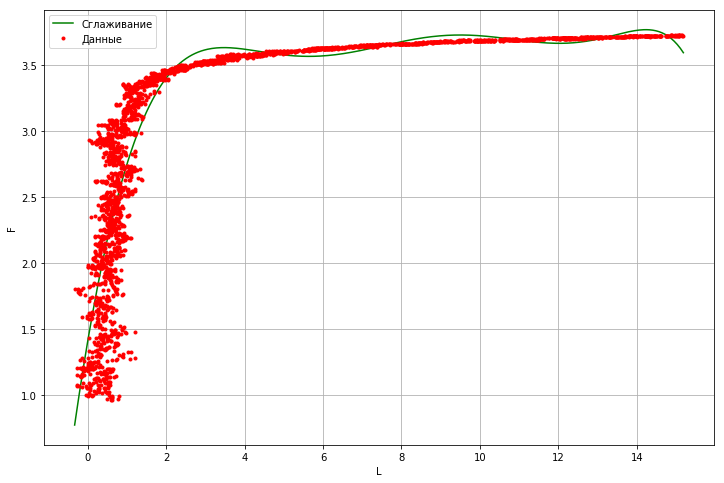

In [64]:
make_plot(fr[params[2]],
          fr[params[1]], 
          lab_x='L', 
          lab_y='F',
          linear=False,
          interpolate_type="polynomial_r",
          degree=7)
          #err_y=0.05*x9[2])